In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cat_mod.models.hmm import HMMFitter
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import multinomial_proportions_confint

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['lines.markersize'] = 10 
matplotlib.rcParams['lines.linewidth'] = 2 

In [2]:
def prepare_data(path, drop_cols, drop_rows, sheet):
    df = pd.read_excel('data/seuqeunces_final_11_06_25.xlsx', sheet_name=sheet)
    df = df.drop(drop_cols, axis=1).drop(drop_rows, axis=0)
    return df.iloc[:, :80], df.iloc[:, 80:]

def map_colours(data, nan=-1, min_count=0):
    colours = data.stack().value_counts()
    col_to_numb = dict()
    for i, col in enumerate(colours.index):
        if colours.loc[col] > min_count:
            col_to_numb[col] = i
        else:
            col_to_numb[col] = nan
    data.replace(col_to_numb, inplace=True)
    data.fillna(nan, inplace=True)
    return data, col_to_numb, colours

def ordering_states_by_prior(model):
    column_order = np.argsort(np.diag(model.transmat_))
    model.startprob_ = model.startprob_[column_order]
    model.transmat_ = model.transmat_[:, column_order]
    model.transmat_ = model.transmat_[column_order, :]
    model.emissionprob_ = model.emissionprob_[column_order, :]

# No red train

In [238]:
no_red1_train, no_red1_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [0, 1, 3, 4], sheet=0)
no_red2_train, no_red2_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [0, 5], sheet=2)
no_red_train = pd.concat([no_red1_train, no_red2_train]).reset_index(drop=True)
no_red_train_num, color_to_num, freqs = map_colours(no_red_train, min_count=0, nan=0)
print(color_to_num)
print(freqs)

{0: 0, 'желтая': 1, 'золотая': 2, 'белая': 3, 'синяя': 4, 'зеленая': 5, 'черная': 6, 'серебряная': 7}
0             1882
желтая         241
золотая        129
белая           97
синяя           82
зеленая         28
черная          17
серебряная       1
Name: count, dtype: int64


/tmp/ipykernel_45144/939334744.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(col_to_numb, inplace=True)


In [241]:
no_red2_train.shape

(18, 80)

In [240]:
no_red_train.shape

(31, 80)

In [44]:
seeds = np.random.randint(10000, size=20)
# seeds = [4641, 5933, 2253, 3278, 1052, 7274, 9424, 1668,  164, 2316]
conf = dict(
    n_components=[1, 2, 3, 4, 5],
    seeds = seeds,
    # n_components = [2],
    # seeds = [42],
    max_iter=2000,
    tol=0.001,
    #filter_colors = [0],
    account_frequencies=False,
    max_cells_per_column=20,
    min_cells_per_column=2,
    verbose=False
)

In [5]:
X = no_red_train.to_numpy().astype(np.int32)

In [6]:
model = HMMFitter(X)
scores = model.fit_model(
    **conf
)

Total data points: 2480, obs states: 8


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

Components f1, total parameters: 9
Components f2, total parameters: 20


 40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 2/5 [00:12<00:18,  6.31s/it]

Components f3, total parameters: 33


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 3/5 [00:28<00:20, 10.28s/it]

Components f4, total parameters: 48


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4/5 [00:50<00:14, 14.75s/it]

Components f5, total parameters: 65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:26<00:00, 17.25s/it]


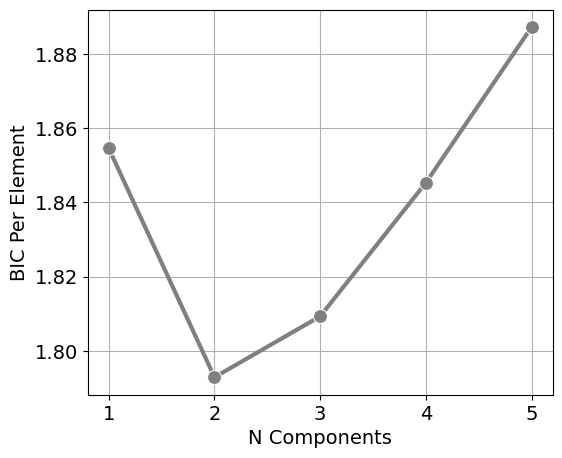

In [59]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(
    model.scores, x='n_comp', y='bic', ax=ax, 
    color='gray', marker="o", estimator='min', 
    errorbar=None, err_style='bars', linewidth=3
)
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
ax.set_xticks(np.arange(len(conf['n_components']))+1)
plt.savefig('bic_no_red_train.png', bbox_inches='tight', dpi=300)

In [8]:
color_to_num

{0: 0,
 'желтая': 1,
 'золотая': 2,
 'белая': 3,
 'синяя': 4,
 'зеленая': 5,
 'черная': 6,
 'серебряная': 7}

In [9]:
y_labels = ['food', 'yellow', 'golden', 'white', 'blue', 'green', 'black', 'silver']

In [41]:
ordering_states_by_prior(model.model)
prior = model.model.startprob_[None].copy()
trans = model.model.transmat_.copy()
emission = model.model.emissionprob_.copy()

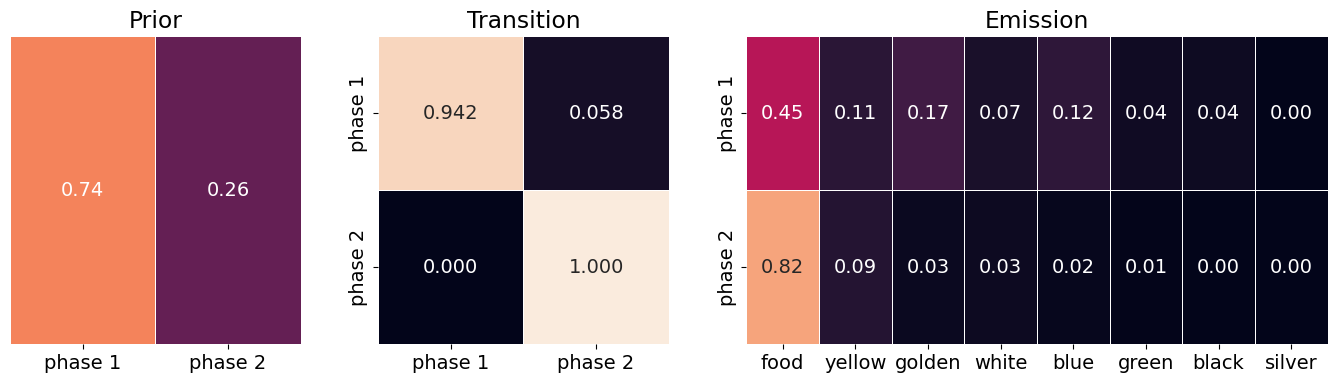

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4), width_ratios=[1, 1, 2])
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None
)
sns.heatmap(prior, ax=ax[0], fmt='0.2f', **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks([0.5, 1.5], labels=['phase 1', 'phase 2'])
sns.heatmap(trans, ax=ax[1], fmt='0.3f', **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks([0.5, 1.5], labels=['phase 1', 'phase 2'])
ax[1].set_yticks([0.5, 1.5], labels=['phase 1', 'phase 2'])
sns.heatmap(emission, ax=ax[2], fmt='0.2f', **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks([0.5, 1.5], labels=['phase 1', 'phase 2'])
ax[2].set_xticklabels(y_labels)
plt.savefig('matrices_no_red_train_best.png', bbox_inches='tight', dpi=300)

In [23]:
conf['n_components'] = [3]
model_3comp = HMMFitter(X)
scores = model_3comp.fit_model(
    **conf
)

Total data points: 2480, obs states: 8


  0%|                                                                                                                                                                                                         | 0/1 [00:00<?, ?it/s]

Components f3, total parameters: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.56s/it]


In [24]:
ordering_states_by_prior(model_3comp.model)
prior = model_3comp.model.startprob_[None].copy()
trans = model_3comp.model.transmat_.copy()
emission = model_3comp.model.emissionprob_.copy()

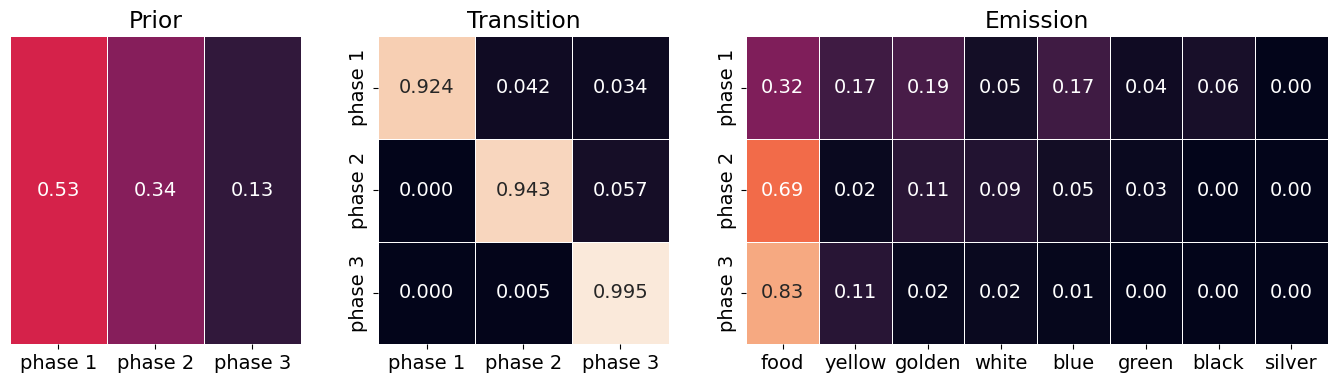

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4), width_ratios=[1, 1, 2])
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None
)
sns.heatmap(prior, ax=ax[0], fmt='0.2f', **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
sns.heatmap(trans, ax=ax[1], fmt='0.3f', **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
ax[1].set_yticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
sns.heatmap(emission, ax=ax[2], fmt='0.2f', **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks([0.5, 1.5, 2.5], labels=['phase 1', 'phase 2', 'phase 3'])
ax[2].set_xticklabels(y_labels)
plt.savefig('matrices_no_red_train_3comp.png', bbox_inches='tight')

In [15]:
# add bars with frequency realtions
# 1. decode sequences
# 2. split them in two phases
# 3. compute average frequences over phases for all sequnces

In [26]:
model.model.algorithm='map'

In [27]:
likelihood, X_decoded = model.model.decode(X.flatten()[:, None], lengths=[X.shape[1]] * X.shape[0])

In [28]:
X_decoded = X_decoded.reshape(X.shape)

In [29]:
freqs_pre = np.zeros(model.model.n_features)
freqs_post = np.zeros(model.model.n_features)
freqs_pre_inds = list()
freqs_post_inds = list()
for dec_seq, seq in zip(X_decoded, X):
    clrs_pre, counts_pre = np.unique(seq[~dec_seq.astype(np.bool)], return_counts=True)
    freqs_pre_ind = np.zeros_like(freqs_pre)
    freqs_pre_ind[clrs_pre] = counts_pre
    freqs_pre_inds.append(freqs_pre_ind / (counts_pre.sum() + 1e-25))
    freqs_pre[clrs_pre] += counts_pre
    
    clrs_post, counts_post = np.unique(seq[dec_seq.astype(np.bool)], return_counts=True)
    freqs_post_ind = np.zeros_like(freqs_post)
    freqs_post_ind[clrs_post] = counts_post
    freqs_post_inds.append(freqs_post_ind / (counts_post.sum() + 1e-25))
    freqs_post[clrs_post] += counts_post

In [30]:
intervals_pre = multinomial_proportions_confint(freqs_pre, method='goodman')
print(intervals_pre)

[[0.35397522 0.49117679]
 [0.08030135 0.17126669]
 [0.13382238 0.24162406]
 [0.04070337 0.11279428]
 [0.08900525 0.18320919]
 [0.02167782 0.08020383]
 [0.01988922 0.07683083]
 [0.         0.01929605]]


In [31]:
intervals_post = multinomial_proportions_confint(freqs_post, method='goodman')
print(intervals_post)

[[7.97447574e-01 8.43128881e-01]
 [7.73893352e-02 1.12162824e-01]
 [2.01808786e-02 4.03069875e-02]
 [2.45718251e-02 4.63550647e-02]
 [9.82806276e-03 2.50367451e-02]
 [2.64791924e-03 1.22878433e-02]
 [1.71358755e-04 5.27438224e-03]
 [5.08225707e-05 4.44591627e-03]]


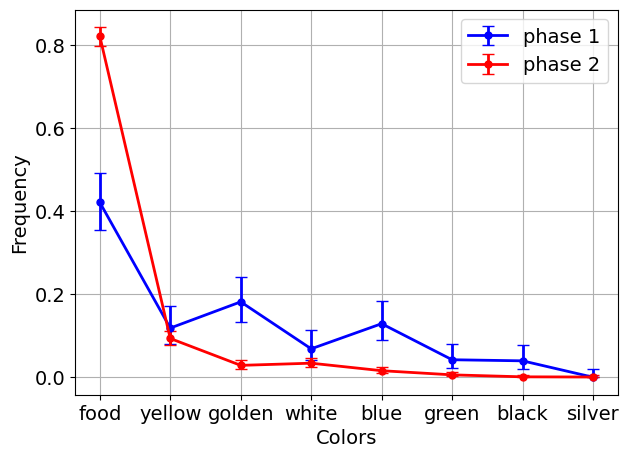

In [64]:
freqs_pre /= freqs_pre.sum()
freqs_post /= freqs_post.sum()
x = np.arange(freqs_pre.size)
ecfg = dict(capsize=4, elinewidth=2, capthick=1, fmt='.-')
plt.figure(figsize=(7, 5))
plt.errorbar(x, freqs_pre, yerr=np.array([(f-ci[0], ci[1]-f) for f, ci in zip(freqs_pre, intervals_pre)]).T, label='phase 1', color='b', **ecfg)
plt.errorbar(x, freqs_post, yerr=np.array([(f-ci[0], ci[1]-f) for f, ci in zip(freqs_post, intervals_post)]).T, label='phase 2', color='r', **ecfg)
plt.legend()
plt.grid()
plt.xticks(ticks=x, labels=y_labels)
plt.xlabel('Colors')
plt.ylabel('Frequency')
plt.savefig('no_red_train_freqs.png', bbox_inches='tight', dpi=300)

## ttest

In [65]:
freqs_pre_inds = np.vstack(freqs_pre_inds)
freqs_post_inds = np.vstack(freqs_post_inds)

In [66]:
tttest_restuls_no_red = dict()

In [67]:
freqs_pre_inds.mean(axis=0)

array([0.25472484, 0.08163039, 0.1235083 , 0.04264813, 0.10273947,
       0.04970116, 0.02246706, 0.        ])

In [68]:
freqs_post_inds.mean(axis=0)

array([8.21894476e-01, 8.98754002e-02, 2.85922897e-02, 3.44852847e-02,
       1.75945528e-02, 6.18047570e-03, 9.29492323e-04, 4.48028674e-04])

In [69]:
pvalues = ttest_ind(freqs_pre_inds, freqs_post_inds, equal_var=False).pvalue

In [70]:
pd.DataFrame({color: [pval] for color, pval in zip(y_labels, pvalues)})

,food,yellow,golden,white,blue,green,black,silver
0,3.480098e-14,0.734234,0.000379,0.613389,0.006521,0.016854,0.013532,0.325309


In [29]:
conf = dict(
    n_components=[1, 2, 3, 4, 5],
    seeds = [32, 432, 333, 4324, 86958],
    # n_components = [2],
    # seeds = [42],
    max_iter=1000,
    tol=0.01,
    filter_colors = [0],
    account_frequencies=False,
    max_cells_per_column=20,
    min_cells_per_column=2,
    verbose=False
)

In [30]:
model_no_food = HMMFitter(X)
scores = model_no_food.fit_model(
    **conf
)

Total data points: 595, obs states: 7


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

Components f1, total parameters: 8
Components f2, total parameters: 18


 40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 2/5 [00:00<00:00,  4.11it/s]

Components f3, total parameters: 30


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 3/5 [00:01<00:00,  2.01it/s]

Components f4, total parameters: 44


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4/5 [00:02<00:00,  1.17it/s]

Components f5, total parameters: 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


In [31]:
model_no_food.scores.groupby(model_no_food.scores['n_comp']).agg(['mean', 'std'])

seed                   score                 aic            \
           mean           std      mean       std      mean       std   
n_comp                                                                  
1       18415.8  38356.814352 -1.522484  0.000000  3.065136  0.000000   
2       18415.8  38356.814352 -1.467791  0.024230  2.986002  0.048459   
3       18415.8  38356.814352 -1.475444  0.021852  3.038283  0.043705   
4       18415.8  38356.814352 -1.430848  0.009455  2.992788  0.018911   
5       18415.8  38356.814352 -1.412731  0.012401  3.006975  0.024802   

             bic            
            mean       std  
n_comp                      
1       3.109390  0.000000  
2       3.096638  0.048459  
3       3.230052  0.043705  
4       3.280442  0.018911  
5       3.405265  0.024802

In [32]:
shuffled_no_food = HMMFitter(X_shuffled)
scores_shuffled = shuffled_no_food.fit_model(
    **conf
)

NameError: name 'X_shuffled' is not defined

In [ ]:
shuffled_no_food.scores.groupby('n_comp').agg(['mean', 'std'])

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(shuffled_no_food.scores, x='n_comp', y='bic', ax=ax, label='shuffled')
sns.lineplot(model_no_food.scores, x='n_comp', y='bic', ax=ax, label='original')
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
plt.savefig('bic_no_red_train_no_food.png')

In [ ]:
conf['n_components'] = [2]
conf['seeds'] = [243, 42, 234, 1124, 44980]
model_no_food = HMMFitter(X)
scores = model_no_food.fit_model(
    **conf
)

In [ ]:
y_labels = ['food', 'yellow', 'golden', 'white', 'blue', 'green', 'black']

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None
)
sns.heatmap(model_no_food.model.startprob_[None], ax=ax[0], **cfg)
ax[0].set_title('Prior')
sns.heatmap(model_no_food.model.transmat_, ax=ax[1], **cfg)
ax[1].set_title('Transition')
sns.heatmap(model_no_food.model.emissionprob_, ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_xticklabels(y_labels[1:])
plt.savefig('matrices_no_food.png')

In [ ]:
conf['n_components'] = [2]
shuffled_no_food = HMMFitter(X_shuffled)
scores_shuffled = shuffled_no_food.fit_model(
    **conf
)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None
)
sns.heatmap(shuffled_no_food.model.startprob_[None], ax=ax[0], **cfg)
ax[0].set_title('Prior')
sns.heatmap(shuffled_no_food.model.transmat_, ax=ax[1], **cfg)
ax[1].set_title('Transition')
sns.heatmap(shuffled_no_food.model.emissionprob_, ax=ax[2], **cfg)
ax[2].set_title('Emission')
ax[2].set_xticklabels(y_labels[1:])

# Separate groups

In [33]:
# add ttest for red for test between no red -> red and red -> red

## no red -> no red

In [431]:
no_red1_train, no_red1_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [0, 1, 3, 4], sheet=0)
no_red1 = pd.concat([no_red1_train, no_red1_test], axis=1).reset_index(drop=True)
no_red1_num, color_to_num, freqs = map_colours(no_red1, min_count=0, nan=0)
print(color_to_num)
print(freqs)

{0: 0, 'желтая': 1, 'золотая': 2, 'белая': 3, 'синяя': 4, 'зеленая': 5, 'черная': 6, 'серебряная': 7}
0             1478
желтая         150
золотая         67
белая           52
синяя           42
зеленая         13
черная          13
серебряная       1
Name: count, dtype: int64


/tmp/ipykernel_45144/939334744.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(col_to_numb, inplace=True)


In [432]:
no_red1.shape

(13, 140)

In [433]:
X = no_red1_num.to_numpy().astype(np.int32)

trans_color = max(list(color_to_num.values())) + 1

X_merged = np.zeros((X.shape[0], X.shape[1]+1), dtype=np.int32)
X_merged[:, :80] = X[:, :80]
X_merged[:, 81:] = X[:, 80:]
X_merged[:, 80] = trans_color

X_train, X_test = X[:, :80], X[:, 80:]

In [434]:
X_test.shape

(13, 60)

In [435]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 6, 4, ..., 0, 0, 2],
       [4, 1, 5, ..., 1, 0, 0],
       [4, 1, 0, ..., 0, 1, 0]], shape=(13, 80), dtype=int32)

In [436]:
X_train[0]

array([0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 5, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [437]:
seeds = np.random.randint(10000, size=20)
# seeds = [4641, 5933, 2253, 3278, 1052, 7274, 9424, 1668,  164, 2316]
conf = dict(
    n_components=[1, 2, 3, 4, 5],
    seeds = seeds,
    # n_components = [2],
    # seeds = [42],
    max_iter=2000,
    tol=0.001,
    #filter_colors = [0],
    account_frequencies=False,
    max_cells_per_column=20,
    min_cells_per_column=2,
    verbose=False
)

In [297]:
model_no_red1 = HMMFitter(X_train)
scores = model_no_red1.fit_model(
    **conf
)

Total data points: 1040, obs states: 7


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

Components f1, total parameters: 8
Components f2, total parameters: 18


 40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 2/5 [00:02<00:04,  1.34s/it]

Components f3, total parameters: 30


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 3/5 [00:08<00:06,  3.16s/it]

Components f4, total parameters: 44


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4/5 [00:12<00:03,  3.69s/it]

Components f5, total parameters: 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.73s/it]


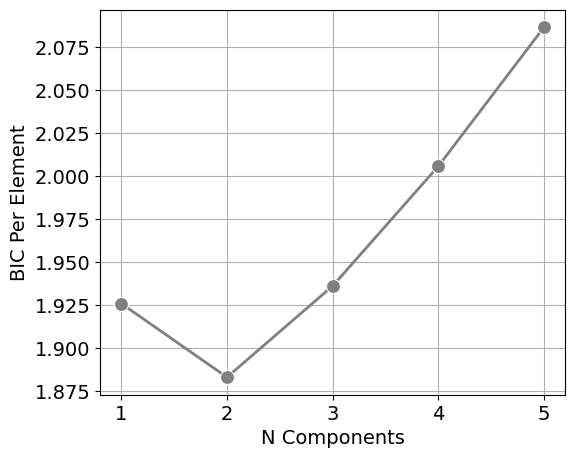

In [298]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(model_no_red1.scores, x='n_comp', y='bic', ax=ax, 
             color='gray', marker="o", estimator='min', errorbar=None, err_style='bars')
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
ax.set_xticks(np.arange(len(conf['n_components']))+1)
plt.savefig('bic_no_red1.png', bbox_inches='tight', dpi=300)

In [438]:
ordering_states_by_prior(model_no_red1.model)
prior = model_no_red1.model.startprob_[None].copy()
trans = model_no_red1.model.transmat_.copy()
emission = model_no_red1.model.emissionprob_.copy()

In [439]:
color_to_num

{0: 0,
 'желтая': 1,
 'золотая': 2,
 'белая': 3,
 'синяя': 4,
 'зеленая': 5,
 'черная': 6,
 'серебряная': 7}

In [440]:
emission.shape

(2, 7)

In [441]:
X_train.shape

(13, 80)

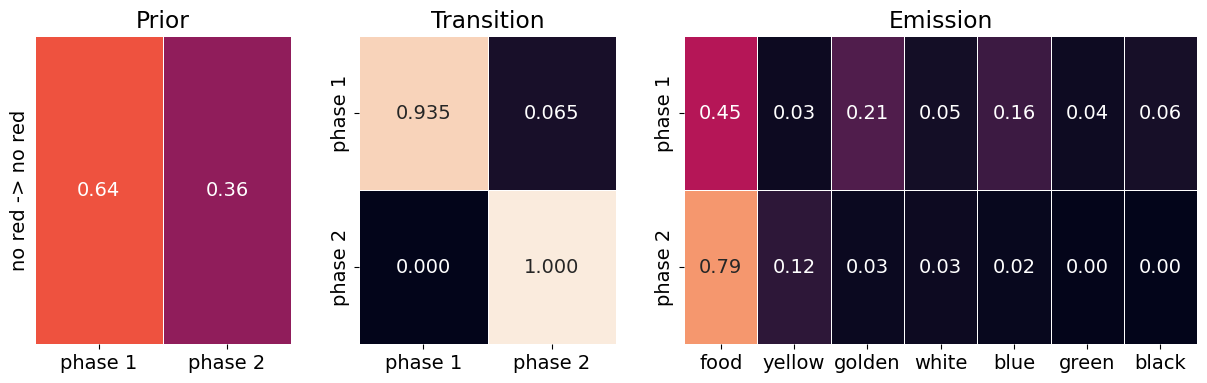

In [442]:
y_labels = ['food', 'yellow', 'golden', 'white', 'blue', 'green', 'black', 'silver']
ticks = [0.5, 1.5, 2.5][:-1]
phases = ['phase 1', 'phase 2', 'phase 3'][:-1]
fig, ax = plt.subplots(1, 3, figsize=(15, 4), width_ratios=[1, 1, 2])
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None
)
sns.heatmap(prior, ax=ax[0], fmt='0.2f', **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks(ticks, labels=phases)
ax[0].set_ylabel('no red -> no red')
sns.heatmap(trans, ax=ax[1], fmt='0.3f', **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks(ticks, labels=phases)
ax[1].set_yticks(ticks, labels=phases)
sns.heatmap(emission, ax=ax[2], fmt='0.2f', **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks(ticks, labels=phases)
ax[2].set_xticklabels(y_labels[:-1])
plt.savefig('matrices_no_red1_best.png', bbox_inches='tight', dpi=300)

In [443]:
model_no_red1.model.algorithm='map'

In [444]:
likelihood, X_decoded = model_no_red1.model.decode(X_train.flatten()[:, None], lengths=[X_train.shape[1]] * X_train.shape[0])

In [445]:
X_decoded = X_decoded.reshape(X_train.shape)

In [446]:
X_decoded[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [447]:
for seq in X_decoded:
    print(seq)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0

In [448]:
color_to_num

{0: 0,
 'желтая': 1,
 'золотая': 2,
 'белая': 3,
 'синяя': 4,
 'зеленая': 5,
 'черная': 6,
 'серебряная': 7}

In [449]:
n_phases = X_decoded.max() + 1
freqs = np.zeros((n_phases, max(color_to_num.values())+1))
freqs_inds = [[] for _ in range(n_phases)]
for dec_seq, seq in zip(X_decoded, X_train):
    for phase in range(n_phases):
        clrs, counts = np.unique(seq[dec_seq == phase], return_counts=True)
        freqs_ind = np.zeros_like(freqs[phase])
        freqs_ind[clrs] = counts
        freqs_inds[phase].append(freqs_ind / (counts.sum() + 1e-25))
        freqs[phase, clrs] += counts

In [450]:
intervals = []
for phase in range(n_phases):
    intervals.append(multinomial_proportions_confint(freqs[phase], method='goodman'))

In [451]:
freqs

array([[ 51.,   3.,  27.,   6.,  19.,   5.,   8.,   0.],
       [725., 111.,  27.,  32.,  21.,   4.,   1.,   0.]])

In [452]:
intervals

[array([[0.31239812, 0.55318984],
        [0.00594341, 0.10061191],
        [0.13993276, 0.34613888],
        [0.01752731, 0.13646754],
        [0.08847907, 0.27108713],
        [0.01330109, 0.12488058],
        [0.02676876, 0.15885246],
        [0.        , 0.05911578]]),
 array([[7.48073468e-01, 8.21676918e-01],
        [9.42019580e-02, 1.52952068e-01],
        [1.75011538e-02, 4.87113509e-02],
        [2.16359617e-02, 5.53468716e-02],
        [1.27087450e-02, 4.05793653e-02],
        [1.21037108e-03, 1.54586217e-02],
        [1.15888169e-04, 1.00909075e-02],
        [0.00000000e+00, 8.05272989e-03]])]

In [453]:
clrs_test, counts_test = np.unique(X_test, return_counts=True)
freqs_test = np.zeros(max(color_to_num.values())+1)
freqs_test[clrs_test] = counts_test

In [454]:
intervals_test = multinomial_proportions_confint(freqs_test, method='goodman')
print(intervals_test)

[[8.72470092e-01 9.30093262e-01]
 [2.95690304e-02 7.13568324e-02]
 [7.96417181e-03 3.45472696e-02]
 [8.80317623e-03 3.62480226e-02]
 [4.61443546e-04 1.41126659e-02]
 [1.42934570e-03 1.82242786e-02]
 [1.42934570e-03 1.82242786e-02]
 [1.36839499e-04 1.18975125e-02]]


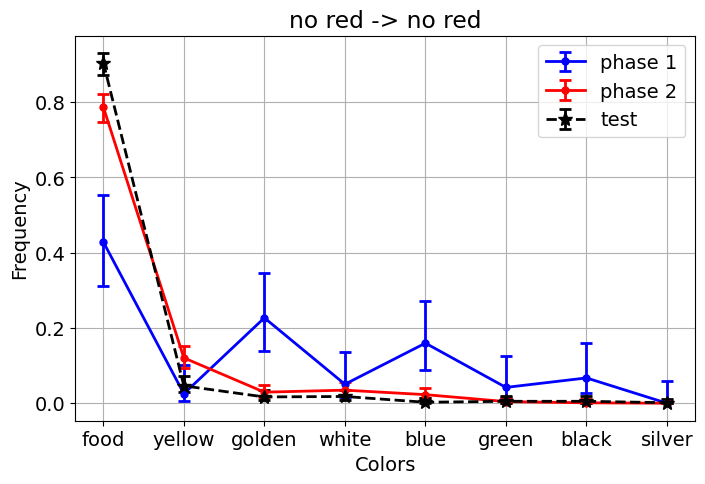

In [459]:
ecfg = dict(capsize=4, elinewidth=2, capthick=2)
colors = ['b', 'r', 'orange']
plt.figure(figsize=(8, 5))
for phase in range(n_phases):
    y = freqs[phase]
    y /= y.sum()
    plt.errorbar(np.arange(y.size), y, yerr=np.array([(max(0, f-ci[0]), max(0, ci[1]-f)) for f, ci in zip(y, intervals[phase])]).T, 
                 label=f'phase {phase + 1}', color=colors[phase], fmt='.-', **ecfg)

freqs_test /= freqs_test.sum()
plt.errorbar(np.arange(freqs_test.size), freqs_test, yerr=np.array([(max(0, f-ci[0]), max(0, ci[1]-f)) for f, ci in zip(freqs_test, intervals_test)]).T, 
             label='test', color='k', fmt='*--', **ecfg)
plt.title('no red -> no red')
plt.legend()
plt.grid()
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.xlabel('Colors')
plt.ylabel('Frequency')
#plt.yscale('log')
plt.savefig('no_red1_freqs.png', bbox_inches='tight', dpi=300)

## ttest

In [460]:
pvalues = ttest_ind(freqs_inds[0], freqs_inds[1], equal_var=False).pvalue

In [461]:
pd.DataFrame({color: [pval] for color, pval in zip(y_labels, pvalues)})

,food,yellow,golden,white,blue,green,black,silver
0,4.337029e-07,0.000184,0.064558,0.830101,0.10991,0.146962,0.117278,NaN


# no red -> red

In [462]:
no_red2_train, no_red2_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [0, 5], sheet=2)
no_red2 = pd.concat([no_red2_train, no_red2_test], axis=1).reset_index(drop=True)
no_red2_num, color_to_num, freqs = map_colours(no_red2, min_count=0, nan=0)
print(color_to_num)
print(freqs)

{0: 0, 'желтая': 1, 'золотая': 2, 'белая': 3, 'синяя': 4, 'зеленая': 5, 'черная': 6, 'серебряная': 7, 'красная': 8}
0             2102
желтая         177
золотая         86
белая           71
синяя           47
зеленая         22
черная           8
серебряная       3
красная          3
Name: count, dtype: int64


/tmp/ipykernel_45144/939334744.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(col_to_numb, inplace=True)


In [463]:
no_red2.shape

(18, 140)

In [464]:
X = no_red2_num.to_numpy().astype(np.int32)

trans_color = max(list(color_to_num.values())) + 1

X_merged = np.zeros((X.shape[0], X.shape[1]+1), dtype=np.int32)
X_merged[:, :80] = X[:, :80]
X_merged[:, 81:] = X[:, 80:]
X_merged[:, 80] = trans_color

X_train, X_test = X[:, :80], X[:, 80:]

In [465]:
seeds = np.random.randint(10000, size=20)
#seeds = [4641, 5933, 2253, 3278, 1052, 7274, 9424, 1668,  164, 2316]
conf = dict(
    n_components=[1, 2, 3, 4, 5],
    seeds = seeds,
    # n_components = [2],
    # seeds = [42],
    max_iter=2000,
    tol=0.001,
    #filter_colors = [0],
    account_frequencies=False,
    max_cells_per_column=20,
    min_cells_per_column=2,
    verbose=False
)

In [324]:
model_no_red2 = HMMFitter(X_train)
scores = model_no_red2.fit_model(
    **conf
)

Total data points: 1440, obs states: 8


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

Components f1, total parameters: 9
Components f2, total parameters: 20


 40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 2/5 [00:03<00:05,  1.88s/it]

Components f3, total parameters: 33


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 3/5 [00:11<00:08,  4.14s/it]

Components f4, total parameters: 48


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4/5 [00:19<00:05,  5.87s/it]

Components f5, total parameters: 65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.46s/it]


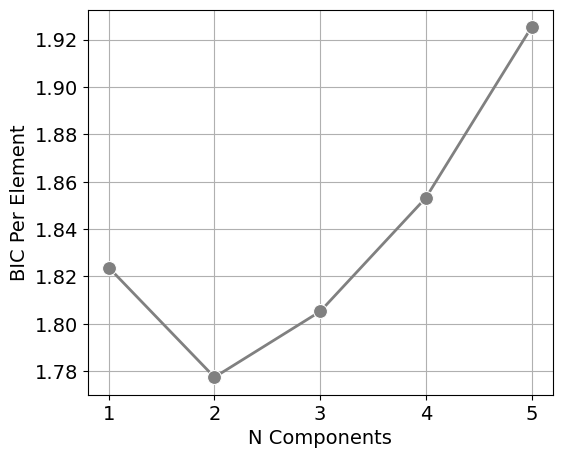

In [325]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(model_no_red2.scores, x='n_comp', y='bic', ax=ax, 
             color='gray', marker="o", estimator='min', errorbar=None, err_style='bars')
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
ax.set_xticks(np.arange(len(conf['n_components']))+1)
plt.savefig('bic_no_red2.png', bbox_inches='tight', dpi=300)

In [466]:
ordering_states_by_prior(model_no_red2.model)
prior = model_no_red2.model.startprob_[None].copy()
trans = model_no_red2.model.transmat_.copy()
emission = model_no_red2.model.emissionprob_.copy()

In [467]:
color_to_num

{0: 0,
 'желтая': 1,
 'золотая': 2,
 'белая': 3,
 'синяя': 4,
 'зеленая': 5,
 'черная': 6,
 'серебряная': 7,
 'красная': 8}

In [468]:
emission.shape

(2, 8)

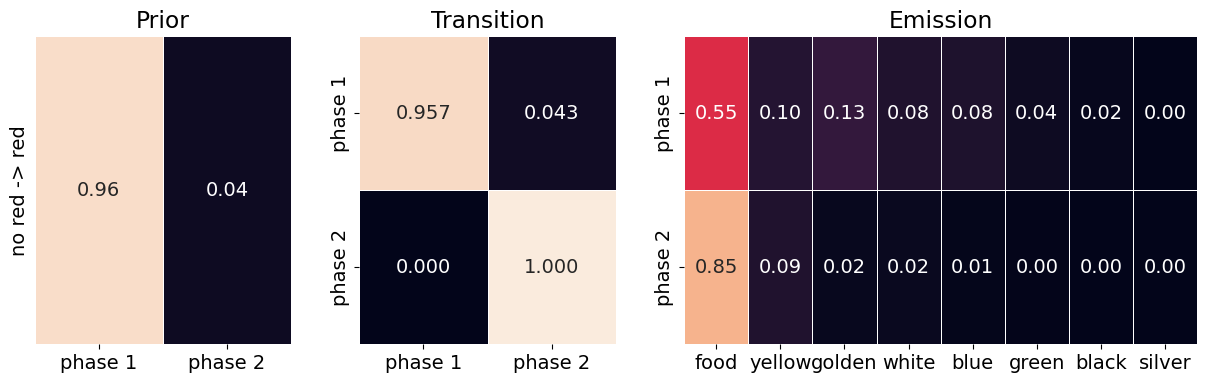

In [469]:
y_labels = ['food', 'yellow', 'golden', 'white', 'blue', 'green', 'black', 'silver', 'red']
ticks = [0.5, 1.5, 2.5][:-1]
phases = ['phase 1', 'phase 2', 'phase 3'][:-1]
fig, ax = plt.subplots(1, 3, figsize=(15, 4), width_ratios=[1, 1, 2])
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None
)
sns.heatmap(prior, ax=ax[0], fmt='0.2f', **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks(ticks, labels=phases)
ax[0].set_ylabel('no red -> red')
sns.heatmap(trans, ax=ax[1], fmt='0.3f', **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks(ticks, labels=phases)
ax[1].set_yticks(ticks, labels=phases)
sns.heatmap(emission, ax=ax[2], fmt='0.2f', **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks(ticks, labels=phases)
ax[2].set_xticklabels(y_labels[:-1])
plt.savefig('matrices_no_red2_best.png', bbox_inches='tight', dpi=300)

In [470]:
model_no_red2.model.algorithm='map'

In [471]:
likelihood, X_decoded = model_no_red2.model.decode(X_train.flatten()[:, None], lengths=[X_train.shape[1]] * X_train.shape[0])

In [472]:
X_decoded = X_decoded.reshape(X_train.shape)

In [473]:
X_decoded

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], shape=(18, 80))

In [474]:
n_phases = X_decoded.max() + 1
freqs = np.zeros((n_phases, max(color_to_num.values())+1))
freqs_inds = [[] for _ in range(n_phases)]
for dec_seq, seq in zip(X_decoded, X_train):
    for phase in range(n_phases):
        clrs, counts = np.unique(seq[dec_seq == phase], return_counts=True)
        freqs_ind = np.zeros_like(freqs[phase])
        freqs_ind[clrs] = counts
        freqs_inds[phase].append(freqs_ind / (counts.sum() + 1e-25))
        freqs[phase, clrs] += counts

In [475]:
intervals = []
for phase in range(n_phases):
    intervals.append(multinomial_proportions_confint(freqs[phase], method='goodman'))

In [476]:
freqs

array([[218.,  34.,  56.,  35.,  33.,  15.,   7.,   0.,   0.],
       [891.,  93.,  19.,  24.,   9.,   4.,   1.,   1.,   0.]])

In [477]:
intervals

[array([[0.47830714, 0.61536065],
        [0.05400944, 0.13255976],
        [0.09916122, 0.19586542],
        [0.05598578, 0.13551331],
        [0.05204229, 0.12959703],
        [0.01880706, 0.07409436],
        [0.00645599, 0.04700636],
        [0.        , 0.01895317],
        [0.        , 0.01895317]]),
 array([[8.22245496e-01, 8.82725153e-01],
        [6.76740608e-02, 1.16846379e-01],
        [9.78043304e-03, 3.37458766e-02],
        [1.32209232e-02, 3.98320168e-02],
        [3.53726296e-03, 2.09357860e-02],
        [1.05287956e-03, 1.38935390e-02],
        [1.00135092e-04, 9.13030521e-03],
        [1.00135092e-04, 9.13030521e-03],
        [0.00000000e+00, 7.32511423e-03]])]

In [478]:
clrs_test, counts_test = np.unique(X_test, return_counts=True)
freqs_test = np.zeros(clrs_test.max()+1)
freqs_test[clrs_test] = counts_test

In [479]:
intervals_test = multinomial_proportions_confint(freqs_test, method='goodman')
print(intervals_test)

[[8.94443867e-01 9.40353509e-01]
 [3.15477569e-02 6.74594808e-02]
 [4.52323692e-03 2.27723319e-02]
 [5.10047367e-03 2.40338559e-02]
 [1.43528125e-03 1.48277232e-02]
 [6.41450279e-04 1.19440326e-02]
 [0.00000000e+00 7.06920071e-03]
 [3.26788300e-04 1.04199339e-02]
 [6.41450279e-04 1.19440326e-02]]


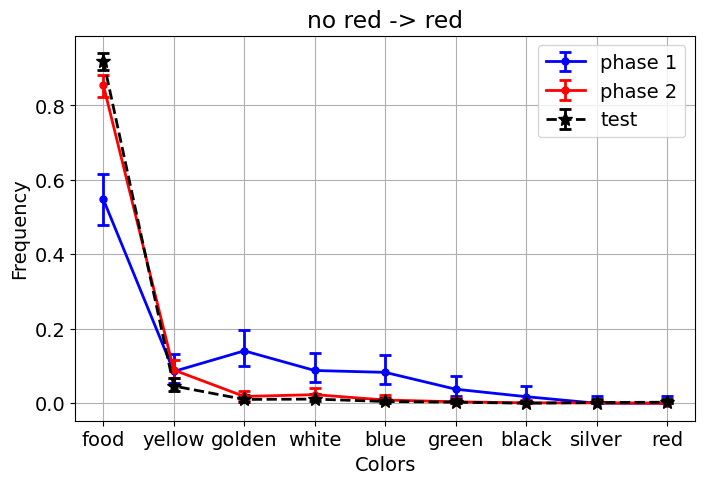

In [481]:
ecfg = dict(capsize=4, elinewidth=2, capthick=2)
colors = ['b', 'r', 'orange']
plt.figure(figsize=(8, 5))
for phase in range(n_phases):
    y = freqs[phase]
    y /= y.sum()
    plt.errorbar(np.arange(y.size), y, yerr=np.array([(max(0, f-ci[0]), max(0, ci[1]-f)) for f, ci in zip(y, intervals[phase])]).T, 
                 label=f'phase {phase + 1}', color=colors[phase], fmt='.-', **ecfg)

freqs_test /= freqs_test.sum()
plt.title('no red -> red')
plt.errorbar(np.arange(freqs_test.size), freqs_test, yerr=np.array([(max(0, f-ci[0]), max(0, ci[1]-f)) for f, ci in zip(freqs_test, intervals_test)]).T, 
             label='test', color='k', fmt='*--', **ecfg)
plt.legend()
plt.grid()
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.xlabel('Colors')
plt.ylabel('Frequency')
#plt.yscale('log')
plt.savefig('no_red2_freqs.png', bbox_inches='tight', dpi=300)

## ttest

In [482]:
pvalues = ttest_ind(freqs_inds[0], freqs_inds[1], equal_var=False).pvalue

In [484]:
pd.DataFrame({color: [pval] for color, pval in zip(y_labels, pvalues)})

,food,yellow,golden,white,blue,green,black,silver,red
0,0.000074,0.321344,0.000185,0.017474,0.028022,0.05789,0.084189,0.331333,NaN


## red -> red

In [485]:
red_train, red_test = prepare_data('data/seuqeunces_final_11_06_25.xlsx', ['name'], [], sheet=1)
red = pd.concat([red_train, red_test], axis=1).reset_index(drop=True)
red_num, color_to_num, freqs = map_colours(red, min_count=0, nan=0)
print(color_to_num)
print(freqs)

{0: 0, 'желтая': 1, 'белая': 2, 'золотая': 3, 'синяя': 4, 'красная': 5, 'зеленая': 6, 'черная': 7, 'серебряная': 8}
0             2283
желтая         193
белая           62
золотая         39
синяя           32
красная         23
зеленая         15
черная           8
серебряная       2
Name: count, dtype: int64


/tmp/ipykernel_45144/939334744.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(col_to_numb, inplace=True)


In [486]:
red_num.shape

(19, 140)

In [487]:
X = red_num.to_numpy().astype(np.int32)

trans_color = max(list(color_to_num.values())) + 1

X_merged = np.zeros((X.shape[0], X.shape[1]+1), dtype=np.int32)
X_merged[:, :80] = X[:, :80]
X_merged[:, 81:] = X[:, 80:]
X_merged[:, 80] = trans_color

X_train, X_test = X[:, :80], X[:, 80:]

In [488]:
seeds = np.random.randint(10000, size=20)
# seeds = [4641, 5933, 2253, 3278, 1052, 7274, 9424, 1668,  164, 2316]
conf = dict(
    n_components=[1, 2, 3, 4, 5],
    seeds = seeds,
    # n_components = [2],
    # seeds = [42],
    max_iter=2000,
    tol=0.001,
    #filter_colors = [0],
    account_frequencies=False,
    max_cells_per_column=20,
    min_cells_per_column=2,
    verbose=False
)

In [349]:
model_red = HMMFitter(X_train)
scores = model_red.fit_model(
    **conf
)

Total data points: 1520, obs states: 9


  0%|                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

Components f1, total parameters: 10
Components f2, total parameters: 22


 40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 2/5 [00:04<00:06,  2.12s/it]

Components f3, total parameters: 36


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 3/5 [00:11<00:08,  4.39s/it]

Components f4, total parameters: 52


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4/5 [00:24<00:07,  7.53s/it]

Components f5, total parameters: 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.00s/it]


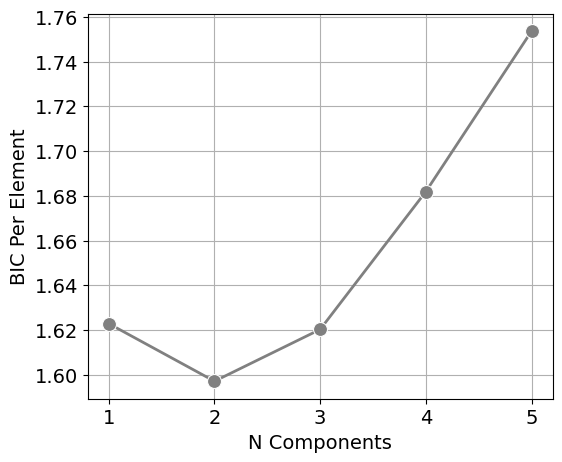

In [350]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(model_red.scores, x='n_comp', y='bic', ax=ax, 
             color='gray', marker="o", estimator='min', errorbar=None, err_style='bars')
plt.grid()
ax.set_xlabel('N Components')
ax.set_ylabel('BIC Per Element')
ax.set_xticks(np.arange(len(conf['n_components']))+1)
plt.savefig('bic_red.png', bbox_inches='tight', dpi=300)

In [489]:
ordering_states_by_prior(model_red.model)
prior = model_red.model.startprob_[None].copy()
trans = model_red.model.transmat_.copy()
emission = model_red.model.emissionprob_.copy()

In [490]:
color_to_num

{0: 0,
 'желтая': 1,
 'белая': 2,
 'золотая': 3,
 'синяя': 4,
 'красная': 5,
 'зеленая': 6,
 'черная': 7,
 'серебряная': 8}

In [491]:
emission.shape

(2, 9)

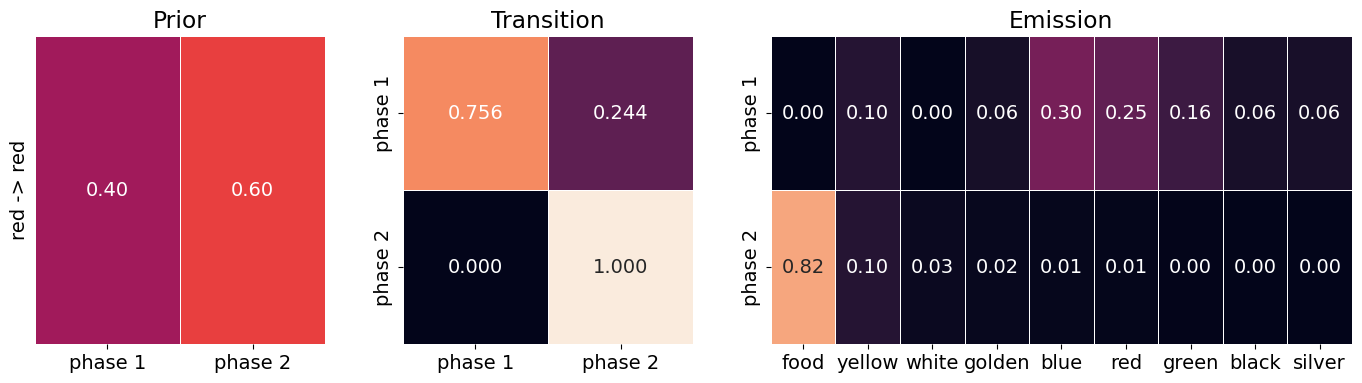

In [492]:
y_labels = ['food', 'yellow', 'white', 'golden', 'blue', 'red', 'green', 'black', 'silver']
ticks = [0.5, 1.5, 2.5][:-1]
phases = ['phase 1', 'phase 2', 'phase 3'][:-1]
fig, ax = plt.subplots(1, 3, figsize=(17, 4), width_ratios=[1, 1, 2])
cfg = dict(
    linewidths=0.5, linecolor='white', vmin=0, vmax=1.0, annot=True, cbar=None
)
sns.heatmap(prior, ax=ax[0], fmt='0.2f', **cfg)
ax[0].set_title('Prior')
ax[0].set_yticks([])
ax[0].set_xticks(ticks, labels=phases)
ax[0].set_ylabel('red -> red')
sns.heatmap(trans, ax=ax[1], fmt='0.3f', **cfg)
ax[1].set_title('Transition')
ax[1].set_xticks(ticks, labels=phases)
ax[1].set_yticks(ticks, labels=phases)
sns.heatmap(emission, ax=ax[2], fmt='0.2f', **cfg)
ax[2].set_title('Emission')
ax[2].set_yticks(ticks, labels=phases)
ax[2].set_xticklabels(y_labels)
plt.savefig('matrices_red_best.png', bbox_inches='tight', dpi=300)

In [493]:
model_red.model.algorithm='map'

In [494]:
likelihood, X_decoded = model_red.model.decode(X_train.flatten()[:, None], lengths=[X_train.shape[1]] * X_train.shape[0])

In [495]:
X_decoded = X_decoded.reshape(X_train.shape)

In [496]:
X_decoded[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [497]:
for seq in X_decoded:
    print(seq)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[0 0 1 1 1 1 1 1

In [498]:
n_phases = X_decoded.max() + 1
freqs = np.zeros((n_phases, max(color_to_num.values())+1))
freqs_inds = [[] for _ in range(n_phases)]
for dec_seq, seq in zip(X_decoded, X_train):
    for phase in range(n_phases):
        clrs, counts = np.unique(seq[dec_seq == phase], return_counts=True)
        freqs_ind = np.zeros_like(freqs[phase])
        freqs_ind[clrs] = counts
        freqs_inds[phase].append(freqs_ind / (counts.sum() + 1e-25))
        freqs[phase, clrs] += counts

In [499]:
intervals = []
for phase in range(n_phases):
    intervals.append(multinomial_proportions_confint(freqs[phase], method='goodman'))

In [500]:
freqs

array([[   0.,    2.,    0.,    2.,   10.,    8.,    5.,    2.,    2.],
       [1223.,  150.,   42.,   31.,   17.,   14.,    7.,    5.,    0.]])

In [501]:
intervals

[array([[0.        , 0.19874058],
        [0.01147448, 0.29065441],
        [0.        , 0.19874058],
        [0.01147448, 0.29065441],
        [0.14648223, 0.56919991],
        [0.10523842, 0.50705541],
        [0.0513597 , 0.40585166],
        [0.01147448, 0.29065441],
        [0.01147448, 0.29065441]]),
 array([[0.79220048, 0.84721088],
        [0.0811195 , 0.12446033],
        [0.01851878, 0.0427425 ],
        [0.01275537, 0.0338068 ],
        [0.00590933, 0.02194488],
        [0.00456051, 0.01928485],
        [0.00172185, 0.01276953],
        [0.00104082, 0.010778  ],
        [0.        , 0.0051374 ]])]

In [502]:
clrs_test, counts_test = np.unique(X_test, return_counts=True)
freqs_test = np.zeros(max(color_to_num.values())+1)
freqs_test[clrs_test] = counts_test

In [503]:
intervals_test = multinomial_proportions_confint(freqs_test, method='goodman')
print(intervals_test)

[[9.08814005e-01 9.50303683e-01]
 [2.35190067e-02 5.46285448e-02]
 [9.55459862e-03 3.19976761e-02]
 [1.79082047e-03 1.53646031e-02]
 [1.35968592e-03 1.40531054e-02]
 [9.15263485e-05 8.35073608e-03]
 [6.07676907e-04 1.13198500e-02]
 [9.15263485e-05 8.35073608e-03]
 [0.00000000e+00 6.69963020e-03]]


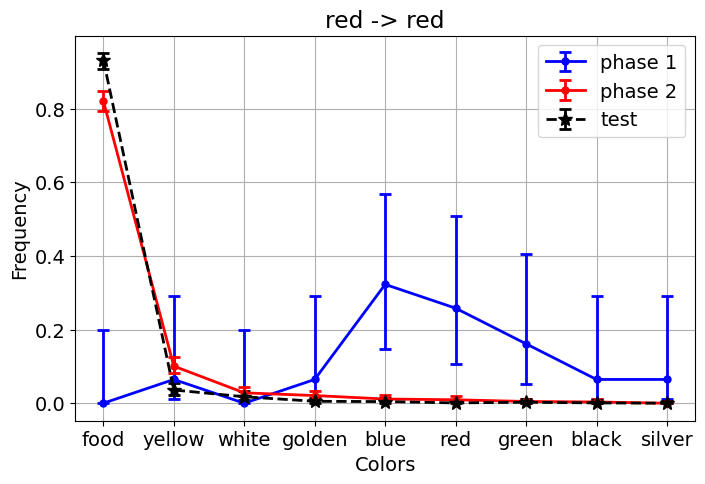

In [504]:
ecfg = dict(capsize=4, elinewidth=2, capthick=2)
colors = ['b', 'r', 'orange']
plt.figure(figsize=(8, 5))
for phase in range(n_phases):
    y = freqs[phase]
    y /= y.sum()
    plt.errorbar(np.arange(y.size), y, yerr=np.array([(max(0, f-ci[0]), max(0, ci[1]-f)) for f, ci in zip(y, intervals[phase])]).T, 
                 label=f'phase {phase + 1}', color=colors[phase], fmt='.-', **ecfg)

freqs_test /= freqs_test.sum()
plt.title('red -> red')
plt.errorbar(np.arange(freqs_test.size), freqs_test, yerr=np.array([(max(0, f-ci[0]), max(0, ci[1]-f)) for f, ci in zip(freqs_test, intervals_test)]).T, 
             label='test', color='k', fmt='*--', **ecfg)
plt.legend()
plt.grid()
plt.xticks(ticks=np.arange(len(y_labels)), labels=y_labels)
plt.xlabel('Colors')
plt.ylabel('Frequency')
#plt.yscale('log')
plt.savefig('red_freqs.png', bbox_inches='tight', dpi=300)

## ttest

In [507]:
pvalues = ttest_ind(freqs_inds[0], freqs_inds[1], equal_var=False).pvalue

In [508]:
pd.DataFrame({color: [pval] for color, pval in zip(y_labels, pvalues)})

,food,yellow,white,golden,blue,red,green,black,silver
0,4.759243e-22,0.000002,0.000007,0.530887,0.023969,0.13014,0.449927,0.359855,0.330565


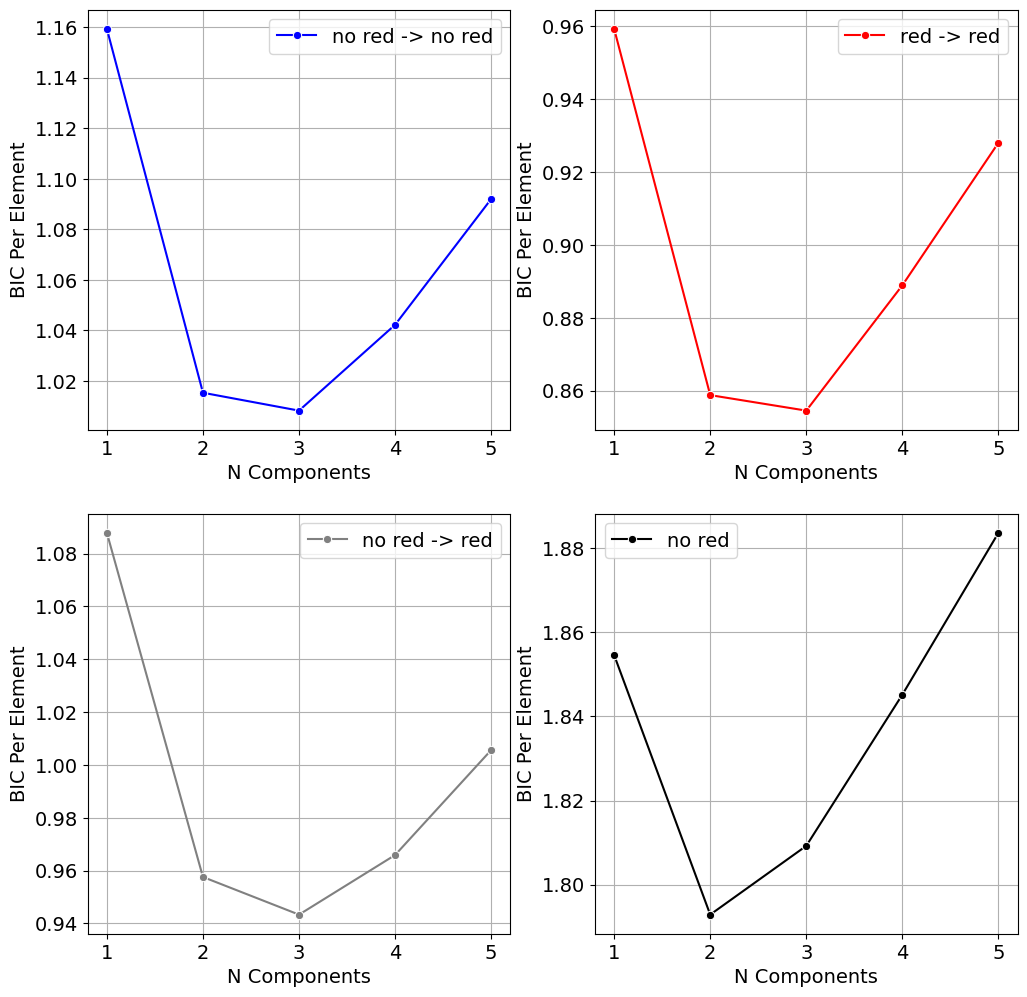

In [110]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

sns.lineplot(model_no_red1.scores, x='n_comp', y='bic', ax=ax[0][0], 
             color='blue', marker="o", estimator='min', errorbar=None, err_style='bars', label='no red -> no red')
sns.lineplot(model_red.scores, x='n_comp', y='bic', ax=ax[0][1], 
             color='red', marker="o", estimator='min', errorbar=None, err_style='bars', label='red -> red')
sns.lineplot(model_no_red2.scores, x='n_comp', y='bic', ax=ax[1][0], 
             color='gray', marker="o", estimator='min', errorbar=None, err_style='bars', label='no red -> red')
sns.lineplot(model.scores, x='n_comp', y='bic', ax=ax[1][1], 
             color='k', marker="o", estimator='min', errorbar=None, err_style='bars', label='no red')

for a in ax:
    for x in a:
        x.grid()
        #plt.legend()
        x.set_xlabel('N Components')
        x.set_ylabel('BIC Per Element')
        x.set_xticks(np.arange(len(conf['n_components']))+1)
plt.savefig('bic_all.png')

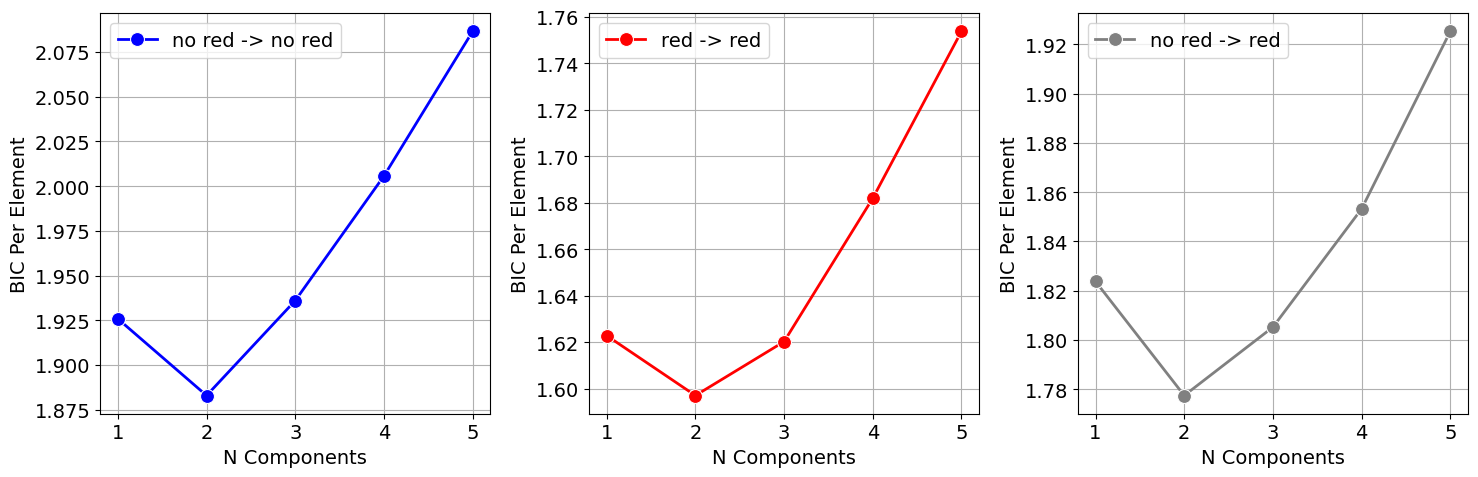

In [373]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.lineplot(model_no_red1.scores, x='n_comp', y='bic', ax=ax[0], 
             color='blue', marker="o", estimator='min', errorbar=None, err_style='bars', label='no red -> no red')
sns.lineplot(model_red.scores, x='n_comp', y='bic', ax=ax[1], 
             color='red', marker="o", estimator='min', errorbar=None, err_style='bars', label='red -> red')
sns.lineplot(model_no_red2.scores, x='n_comp', y='bic', ax=ax[2], 
             color='gray', marker="o", estimator='min', errorbar=None, err_style='bars', label='no red -> red')
for x in ax:
    x.grid()
    #plt.legend()
    x.set_xlabel('N Components')
    x.set_ylabel('BIC Per Element')
    x.set_xticks(np.arange(len(conf['n_components']))+1)
plt.tight_layout()
plt.savefig('bic_all2.png', bbox_inches='tight', dpi=300)